In [1]:
import os
os.chdir("./..")

import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from src.utils import DATA_PATH, MODELS_PATH

In [2]:
# Load data
rfm_metrics_path = os.path.join(DATA_PATH, "rfm_data.csv")
rfm_metrics = pd.read_csv(rfm_metrics_path)
rfm_metrics_scaled_path = os.path.join(DATA_PATH, 'rfm_metrics_scaled.csv')
rfm_metrics_scaled = pd.read_csv(rfm_metrics_scaled_path)
transactions_data_path = os.path.join(DATA_PATH, "online_retail_cleaned.csv")
transactions_data = pd.read_csv(transactions_data_path)

# Load model
model_file_path = os.path.join(MODELS_PATH, "kmeans-k5.pkl")
with open(model_file_path, "rb") as f:
    model = pickle.load(f)
scaler_file_path = os.path.join(MODELS_PATH, "scaler.pkl")
with open(scaler_file_path, "rb") as f:
    robust_scaler = pickle.load(f)

In [3]:
rfm_metrics["cluster"] = model.predict(rfm_metrics_scaled)
rfm_metrics

,recency,frequency,monetary_value,cluster
0,325,1,77183.60,2
1,2,7,4310.00,0
2,75,4,1797.24,0
3,18,1,1757.55,0
4,310,1,334.40,0
...,...,...,...,...
4334,277,1,180.60,0
4335,180,1,80.82,0
4336,7,2,178.05,0
4337,3,16,2094.88,0


In [4]:
centroids = []
inversed_cluster_centers = robust_scaler.inverse_transform(model.cluster_centers_)
for cluster, centroid in enumerate(inversed_cluster_centers):
    recency, frequency, monetary_value = centroid
    centroids.append((recency, frequency, monetary_value, cluster))

centroids = pd.DataFrame(centroids, columns=("recency", "frequency", "monetary_value", "cluster"))
centroids

,recency,frequency,monetary_value,cluster
0,97.763243,2.987068,980.168367,0
1,8.400000,65.000000,149828.502000,1
2,35.320000,47.760000,50909.060000,2
3,18.657343,17.034965,8421.043951,3
4,0.500000,67.000000,269931.660000,4


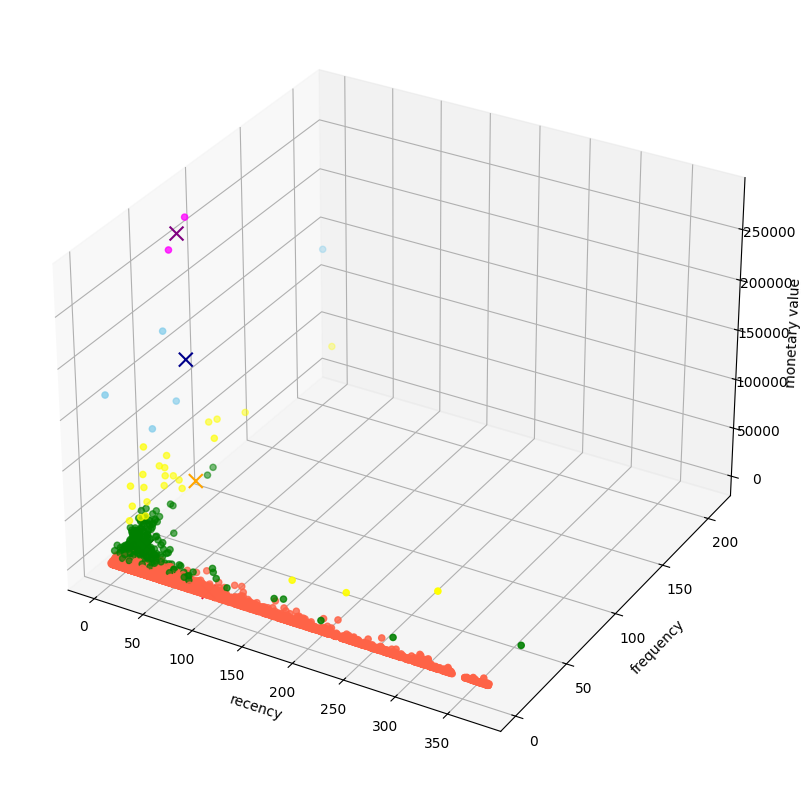

In [5]:
cmap = mcolors.ListedColormap(["tomato", "skyblue", "yellow", "green", "magenta"])
centroid_cmap = mcolors.ListedColormap(["crimson", "darkblue", "orange", "darkgreen", "purple"])

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(rfm_metrics["recency"], rfm_metrics["frequency"], rfm_metrics["monetary_value"], c=rfm_metrics["cluster"], cmap=cmap)
ax.scatter3D(centroids["recency"], centroids["frequency"], centroids["monetary_value"], c=centroids["cluster"], cmap=centroid_cmap, marker='x', alpha=1, s=100)
ax.set_xlabel("recency")
ax.set_ylabel("frequency")
ax.set_zlabel("monetary value")
plt.show()

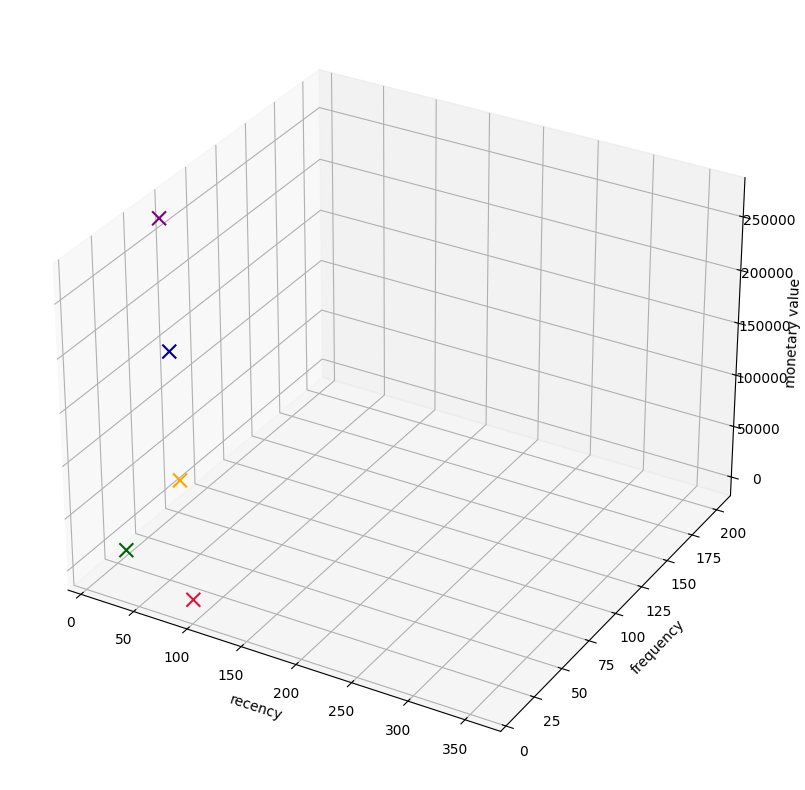

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(centroids["recency"], centroids["frequency"], centroids["monetary_value"], c=centroids["cluster"], cmap=centroid_cmap, marker='x', alpha=1, s=100)
ax.set_xlabel("recency")
ax.set_ylabel("frequency")
ax.set_zlabel("monetary value")
ax.axes.set_xlim3d(right=rfm_metrics.max().loc["recency"])
ax.axes.set_ylim3d(top=rfm_metrics.max().loc["frequency"])
ax.axes.set_zlim3d(top=rfm_metrics.max().loc["monetary_value"])
plt.show()

We see that most customers fall under the red cluster, while some fall in the green cluster. There are very few customers that fall in the yellow, blue and purple clusters. Based on the 3D scatter plots above, we can deduce the following characteristics about the customers in each cluster:

* Red: These customers make very infrequent purchases
* Green: These customers made purchases very recently, and tend to make slightly more frequent purchases than the customers in the red cluster. Given that the dataset was collected around the Christmas period of 2012, it could be that these customers are Christmas shoppers who have purchased gifts from the store. If the dataset was collected around June, we might find that these customers have similar spending habits to those from the red cluster.
* Yellow: These customers make purchases very recently and frequently, and tend to spend more money than the customers from the red and green clusters
* Blue and purple: These customers make purchases almost as frequently as those in the yellow cluster, but they are way bigger spenders than the other clusters in terms of monetary value.

Let's find out how many customers fall into each cluster.

In [7]:
rfm_metrics.groupby("cluster").count().reset_index(drop=False)

,cluster,recency,frequency,monetary_value
0,0,4020,4020,4020
1,1,5,5,5
2,2,25,25,25
3,3,287,287,287
4,4,2,2,2


(In hindsight, perhaps setting k=4 might have been a better idea so that clusters 1 (blue) and 4 (purple) would be clustered together as they are the big spenders of the store.)

In summary, from the brief analysis conducted, it could be concluded that many shoppers are Christmas shoppers. This is also supported by the time plot which we saw from the EDA notebook, which is replicated again below. To increase sales, perhaps more steps could be taken to focus on cluster 3 (green) to increase the frequency of their purchases. For example, giving out shopping vouchers with a 6-month validity could be a strategy to attract Christmas shoppers from the green clusters to make another purchase again within the next 6 months.

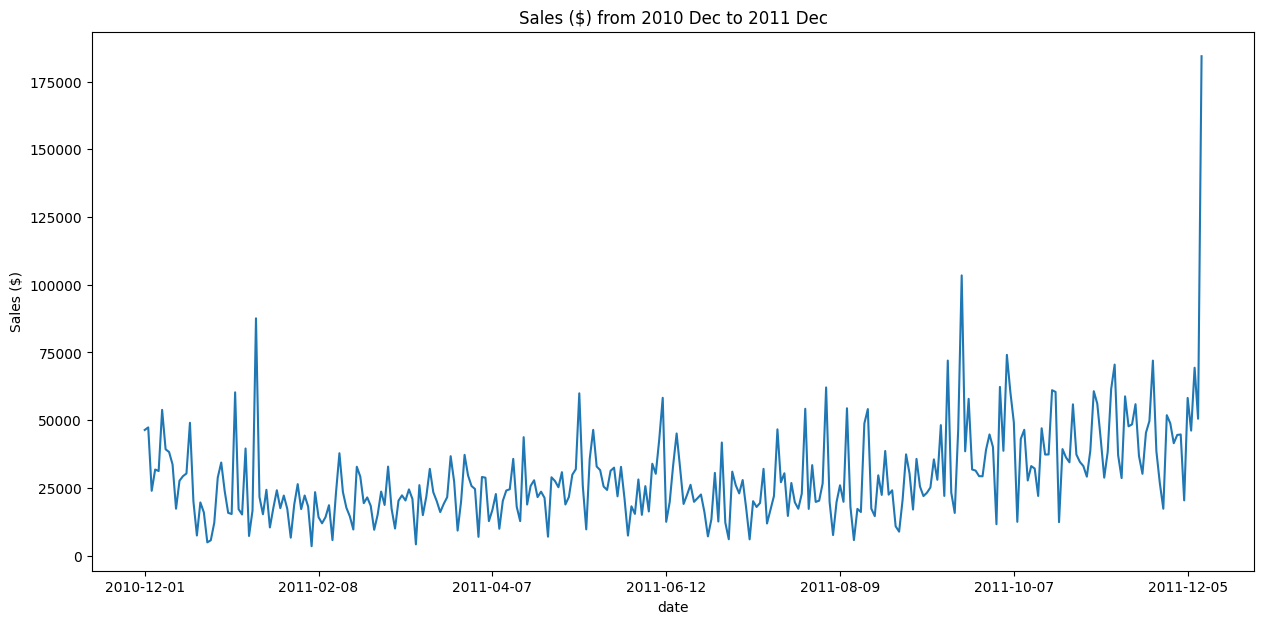

In [8]:
plt.figure(figsize=(15, 7))
transactions_data.groupby('date').TotalPrice.sum().plot()
plt.ylabel("Sales ($)")
plt.title("Sales ($) from 2010 Dec to 2011 Dec")
plt.show()